# Tiền xử lý dữ liệu lâm sàng bệnh Đái tháo đường  

Tài liệu này mô tả quy trình **tiền xử lý dữ liệu lâm sàng** cho bài toán phân loại/tiên lượng **Đái tháo đường (ĐTĐ)** trên bộ dữ liệu *Pima Indians Diabetes*, trong **khung chẩn đoán** đối chiếu giữa **WHO (1999)** và **NDDG (1979)**.

## Mục tiêu
- Mô tả đặc điểm phân bố và mối tương quan giữa các chỉ số lâm sàng (Glucose 2h, BMI, Insulin, Huyết áp, v.v.).
- Xử lý dữ liệu sinh lý học không hợp lệ (giá trị 0 → thiếu), điền trung vị, chuẩn hóa đặc trưng.
- Chia tập huấn luyện/kiểm định và **lưu các artefact tiền xử lý** phục vụ mô hình hóa.

## Ghi chú học thuật
- **WHO 1999**: ngưỡng FPG ≥ 7.0 mmol/L (≥ 126 mg/dL); 2h-OGTT ≥ 11.1 mmol/L (≥ 200 mg/dL); thống nhất thuật ngữ **Type 1/Type 2**.
- **NDDG 1979**: ngưỡng FPG ≥ 7.8 mmol/L (≥ 140 mg/dL) trên nhiều lần; nếu FPG thấp hơn, sử dụng OGTT với tiêu chuẩn nghiêm ngặt hơn; thuật ngữ **IDDM/NIDDM** (nay không còn dùng).



In [9]:
# Setup & data paths
RAW_DATA = r"data/pima-indians-diabetes.data.csv"
PROCESSED_DIR = r"data/processed"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.makedirs(PROCESSED_DIR, exist_ok=True)

columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(RAW_DATA, header=None, names=columns)
print("Shape:", df.shape)
df.head()


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
# Quick summary
df.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


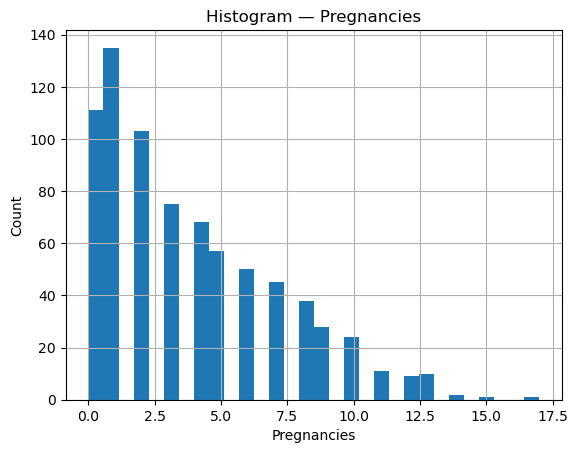

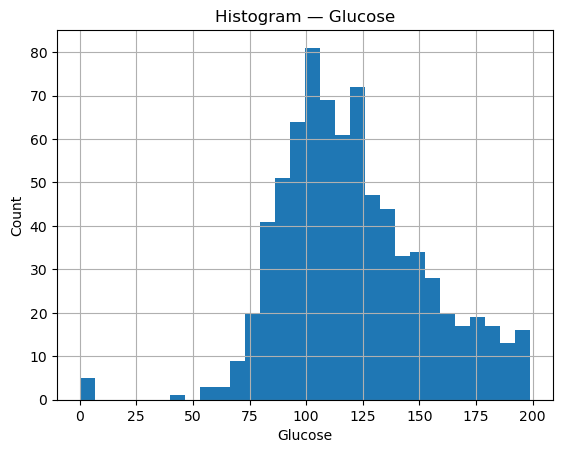

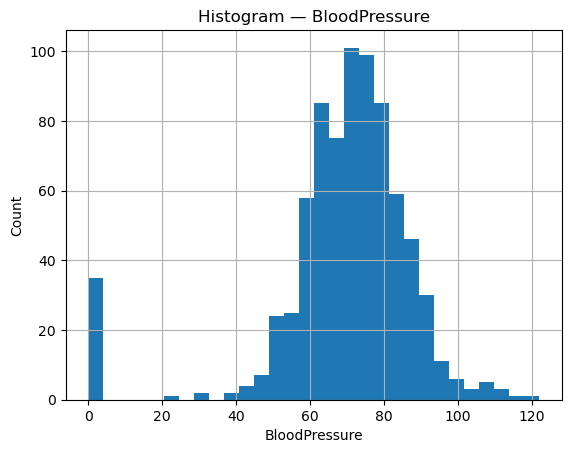

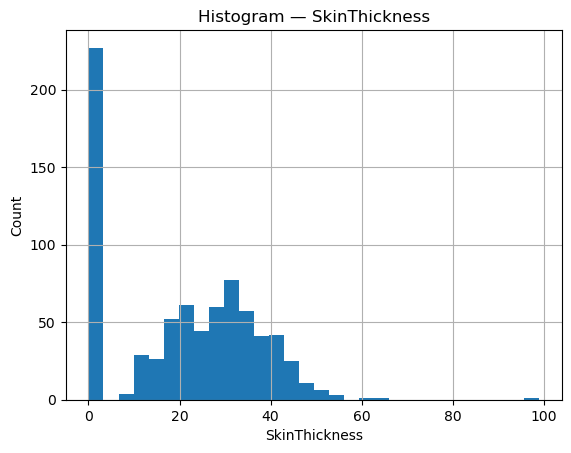

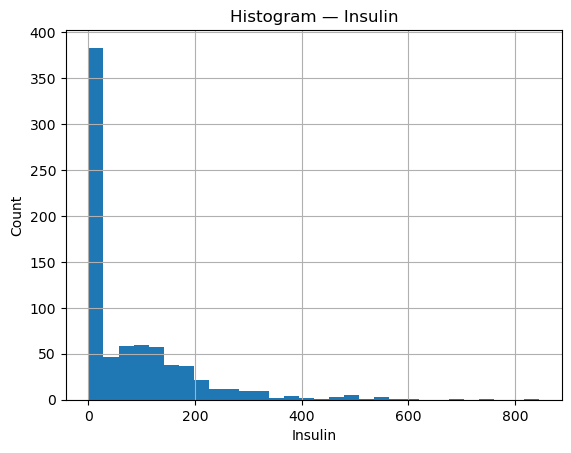

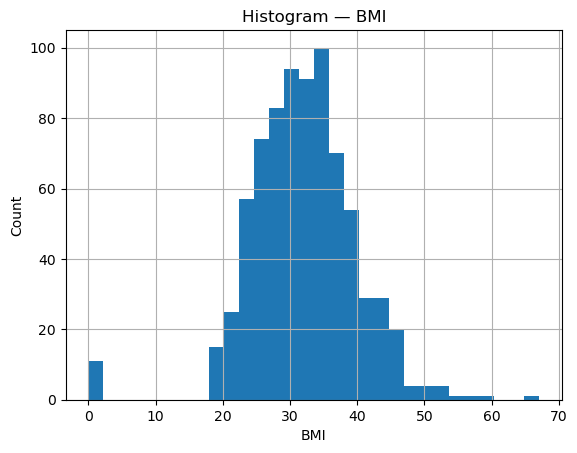

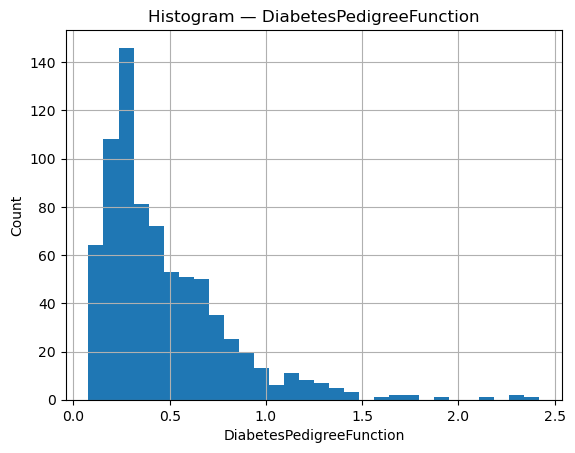

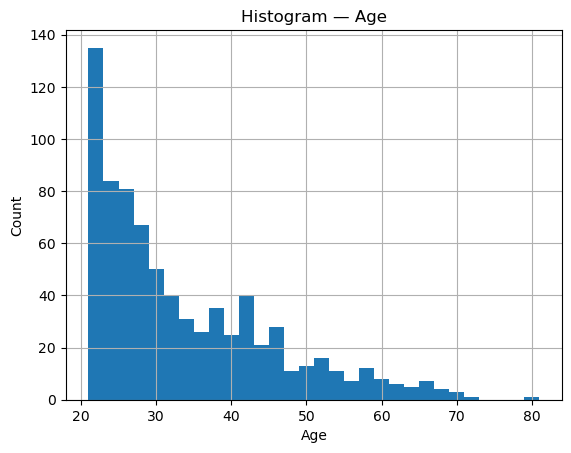

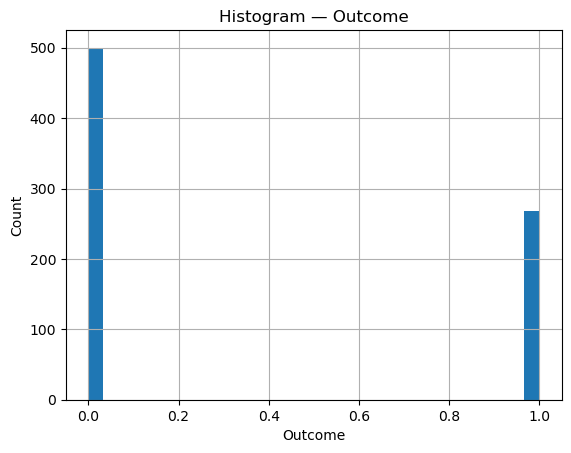

In [11]:
# EDA — Histograms (one chart per figure, matplotlib default styles)
numeric_cols = df.columns.tolist()
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## 2. Chuẩn bị vấn đề (Prepare Problem)

### Khai báo thư viện (Load Libraries)

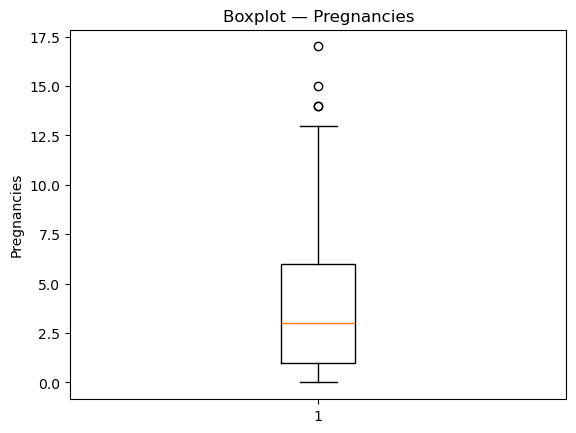

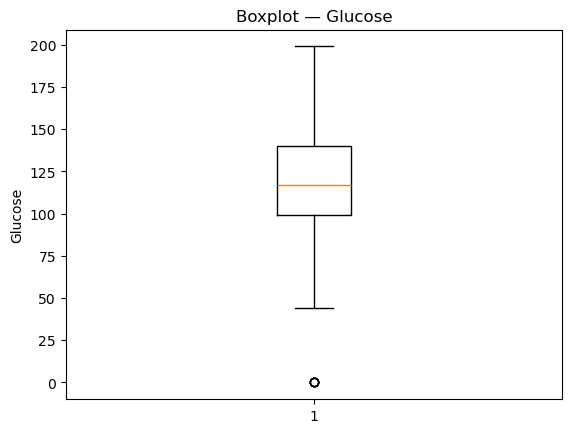

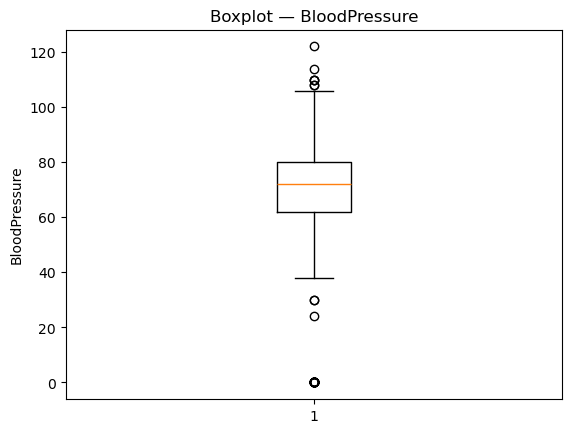

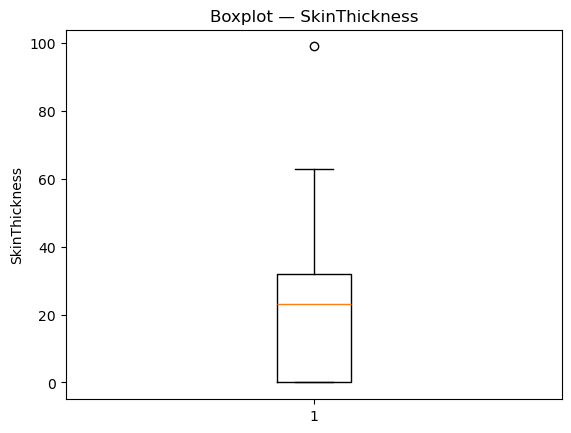

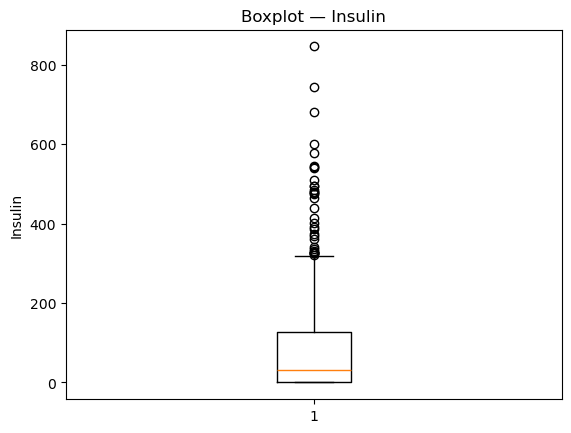

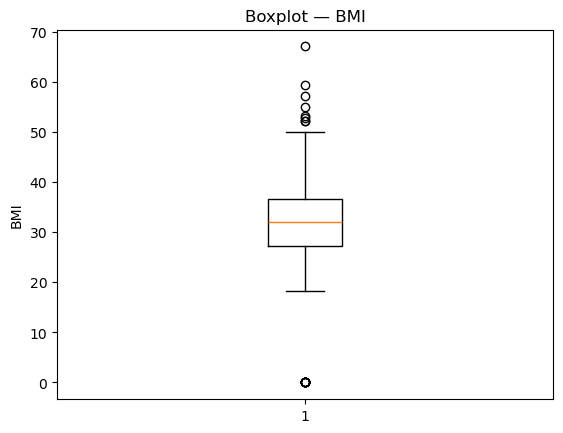

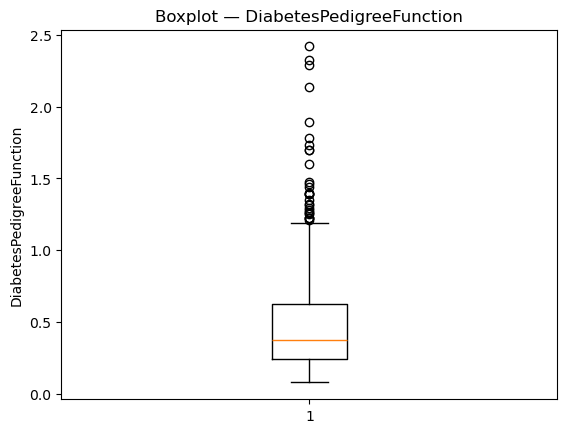

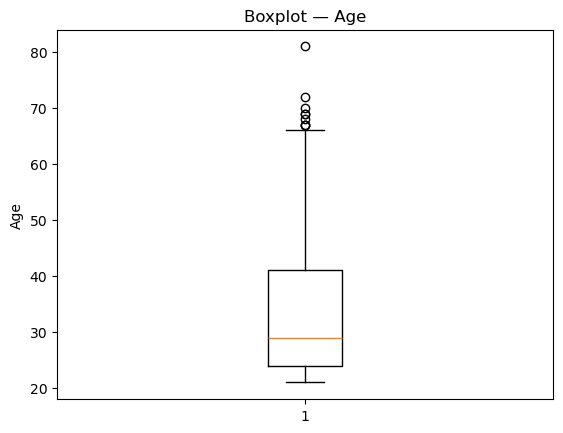

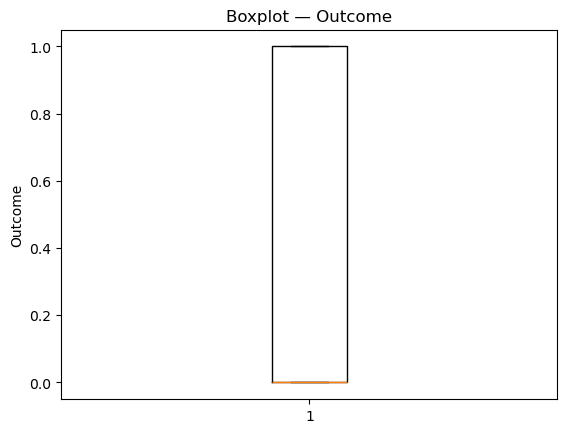

In [12]:
# EDA — Boxplots
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()

### Tham số chương trình

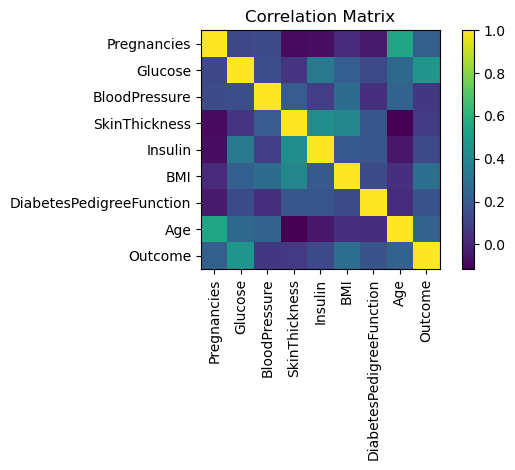

In [13]:
# EDA — Correlation heatmap (matplotlib pcolor)
corr = df.corr(numeric_only=True)
plt.figure()
cax = plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(cax)
plt.tight_layout()
plt.show()

### Nạp dữ liệu (Load Dataset)

In [14]:
# Treat zeros as missing where physiologically implausible
cols_missing_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df_clean = df.copy()
for c in cols_missing_zero:
    df_clean[c] = df_clean[c].replace(0, np.nan)

print("Missing ratios after zero->NaN:")
print(df_clean[cols_missing_zero].isna().mean())

Missing ratios after zero->NaN:
Glucose          0.006510
BloodPressure    0.045573
SkinThickness    0.295573
Insulin          0.486979
BMI              0.014323
dtype: float64


### Chia dữ liệu thực nghiệm

+ Dữ liệu ban đầu: chia 30% dữ liệu dùng để Test, 70% dùng để train
+ Dữ liệu train: chia chiến lược K-Fold với k = 5

In [15]:
# Median imputation
df_imputed = df_clean.copy()
for c in cols_missing_zero:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

# Train/Test split
X = df_imputed.drop(columns=["Outcome"])
y = df_imputed["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save processed artifacts
pd.DataFrame(X_train, columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_train.csv", index=False, header=False)
pd.DataFrame(X_test,  columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_test.csv", index=False, header=False)
pd.Series(y_train).to_csv(f"{PROCESSED_DIR}/y_train.csv", index=False, header=False)
pd.Series(y_test).to_csv(f"{PROCESSED_DIR}/y_test.csv", index=False, header=False)
pd.DataFrame(X_train_scaled, columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_train_scaled.csv", index=False, header=False)
pd.DataFrame(X_test_scaled,  columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_test_scaled.csv", index=False, header=False)

print("Saved processed datasets to:", PROCESSED_DIR)

Saved processed datasets to: data/processed


## 4. Tiền xử lý dữ liệu (Data Preprocessing)

### Làm sạch dữ liệu (Data Cleaning)

In [16]:
# [Thiết lập] — đường dẫn và import
RAW_DATA = r"data/pima-indians-diabetes.data.csv"
PROCESSED_DIR = r"data/processed"

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.makedirs(PROCESSED_DIR, exist_ok=True)

columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(RAW_DATA, header=None, names=columns)
print("Shape:", df.shape)

Shape: (768, 9)


#### Tạo bảng dữ liệu làm sạch
+ Chỉ giữ lại các cột Input, Ouput

#### Xóa dữ liệu trùng nhau

In [17]:
# [Làm sạch dữ liệu] — loại trùng và thay 0->NaN ở biến sinh lý
# Loại bỏ dòng trùng lặp (nếu có)
df = df.drop_duplicates().reset_index(drop=True)

cols_missing_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df_clean = df.copy()
for c in cols_missing_zero:
    df_clean[c] = df_clean[c].replace(0, np.nan)

print("Tỉ lệ thiếu sau khi thay 0->NaN:")
print(df_clean[cols_missing_zero].isna().mean())

Tỉ lệ thiếu sau khi thay 0->NaN:
Glucose          0.006510
BloodPressure    0.045573
SkinThickness    0.295573
Insulin          0.486979
BMI              0.014323
dtype: float64


#### Xử lý giá trị rỗng, không hợp lệ

In [18]:
# [Điền giá trị] — median imputation
df_imputed = df_clean.copy()
for c in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

df_imputed.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Biến đổi dữ liệu (Data Transforms)

In [19]:
# [Biến đổi dữ liệu] — chuẩn hoá & tách tập
X = df_imputed.drop(columns=["Outcome"])
y = df_imputed["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (537, 8) (231, 8)


### Lưu dữ liệu Features

+ Chuyển đổi dữ liệu sang dạng numpy với phần Input (X_data), Output (y_data)
+ Lưu tất cả thông tin để chuẩn bị chạy thuật toán

In [20]:
# [Lưu kết quả tiền xử lý] — artefacts cho các notebook mô hình

# Lưu các file X (dữ liệu đầu vào)
pd.DataFrame(X_train, columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_train.csv", index=False)
pd.DataFrame(X_test,  columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_test.csv", index=False)
pd.DataFrame(X_train_scaled, columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_train_scaled.csv", index=False)
pd.DataFrame(X_test_scaled,  columns=X.columns).to_csv(f"{PROCESSED_DIR}/X_test_scaled.csv", index=False)

# SỬA Ở ĐÂY: Thêm header=False để không lưu dòng tiêu đề cho các file y
pd.Series(y_train).to_csv(f"{PROCESSED_DIR}/y_train.csv", index=False, header=False)
pd.Series(y_test).to_csv(f"{PROCESSED_DIR}/y_test.csv", index=False, header=False)


print("Đã lưu dữ liệu tiền xử lý vào:", PROCESSED_DIR)

Đã lưu dữ liệu tiền xử lý vào: data/processed


# Kết thúc

## Tài liệu tham khảo (trích yếu)
1. WHO Consultation. *Definition, Diagnosis and Classification of Diabetes Mellitus and its Complications.* WHO, 1999.
2. National Diabetes Data Group. *Classification and Diagnosis of Diabetes Mellitus and Other Categories of Glucose Intolerance.* 1979.
3. Ứng dụng mạng nơ-ron (ADAP) cho dự báo ĐTĐ ở quần thể Pima (bản kinh điển).